## Ensemble Learning & Random Forest

wisdom of the crowd
- suppose you pose a complex question to thousands of random people then aggregate the answer
- in many case we will find that this aggregated answer is better than an expert answer 

ensemble
- similarity if we aggregate the prediction of  a group of predictor such as classifier ir regressor we will often get better prediction than with the best individual predictor
- a group of predictor is called an ensemble 
- this technique is called ensemble learning 
- and an ensemble learning algorithm is called an ensemble method 

random forest 
- ensemble of decision trees 
- this is one of the most powerfull machine learning algorithms available today 

### Voting Classifier

Hard Votting Classifier
- suppose yo have trained a few classifiers 
- each one achieving about 80% accuracy 
- you way have a logistic regression classifierm an svm classifier, a random forest classifier ans few more 
- a very simple way to create an even better classifier is to aggregate the prediction of each classifier 
- the class get most votes is the ensemble perdiction 
- this called a hard voting classifier
- somewhat surprisingly this voting classifier often achieves a higher accuracy than the best classifier in the ensemble 
- in fact even if each classifier is a weak learner, the ensemble can still be a strong learner
- provided there are a sufficient number of weak learner in the ensemble and they sufficient diverse


Tip
- ensemble methid work best when the predictor are as independent from one another as possible 
- one way to get diverse classifier is to train them using very different algorithm
- this increase the change that they will make very different types of error, improving the ensemble accuracy

In [1]:
from sklearn.datasets import make_moons
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC 

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

voting_clf = VotingClassifier(estimators=[
    ('lr', LogisticRegression(random_state=42)),
    ('rf', RandomForestClassifier(random_state=42)),
    ('svc', SVC(random_state=42))
])

voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

- when we fit a votingclassifier it clone every estimator and fits the clones 
- the original estimator are available via the estimator attribute, while the fitted clones are available via the estimators_ attributes
- if we prefer a dict ratger than a list we can use named_estimators or named_estimators_ instead, 


In [2]:
for name, clf in voting_clf.named_estimators_.items():
    print(name, "=", clf.score(X_test, y_test))

lr = 0.864
rf = 0.896
svc = 0.896


- when we call the votting classfifier predict() method it perform hard voting 
- example, the voting clasdifier predict class 1 for the first instance of test set, because two of out of tthree classifier predict that class

In [3]:
voting_clf.predict(X_test[:1])

array([1])

In [4]:
[clf.predict(X_test[:1]) for clf in voting_clf.estimators_]

[array([1]), array([1]), array([0])]

- now lets look at the performance of the votting classifier on test set

In [5]:
voting_clf.score(X_test, y_test)

0.912

- votting classifier outperform all the individual classifiers

Soft Votting
- if all classfier are able to estimate class probabilities (if they all have a predict_proba() method)
- they we can tell scikit learn to predict the class woth the hgighest probabilitu, averaged over all the individual classifiers
- this is called soft voting, it often achieves higher performance than hard voting because it gives more weight to highly confident votes 
- all we need to do is set the votting classifier voting hyperparamter to soft
- and ensure that all classifier can estimate class probabilities

In [6]:
voting_clf.voting = "soft"
voting_clf.named_estimators['svc'].probability = True
voting_clf.fit(X_train, y_train)
voting_clf.score(X_test, y_test)

0.92

- we reach 92% accuracy simply by using soft voting 

### Bagging and Pasting

Bagging & Pasting
- one way to get a diverse set of classifier is to use very different training algorithm
- another aproach is to use the same training algorithm for every predictor but train them on different random subset of the training set 
- Bagging = Sampling is performed with replacement 
- Pasting = Sampling is performed without replacement 
- both bagging and pasting allow training instance to be sampled several times acros multiple predictor but only bagging allow training instance to be sampled several time for the same predictor

- once all predictor are trained, the ensemble can make a predictoon for a new instance bu simple aggreagting the predictoon of all predictors 
- the aggregation function is typically the statistical model for classification (most frequent prediction jus lije a hard voting classifier), or the average for regression
- each individual predictor has a higher bias than if were trained on the original training set, but aggregating reduce both bias and varianve 
- generalu the net result is that the ensemble has a similar bias but lower than a single predictor trained on the original set 

- predictor can all be trained in paralel, via different cpu core on even different servers
- similarly prediction can be made in paralel 
- this os one of the reason bagging and pasting are such popular methods they scale very well

### Bagging and Pasting in scikit learn

BaggingClassifier class or BaggingRegressor for regresion
- ensemble of 500 decision tree classifier
- each is trained on 100 training instance randomly sampled from the training set with replacement (if we need pasting just set bootstrap=False)
- n_jobs parameter tell scikit learn number of cpu core to use for training and prediction and -1 tell scikit lean to use all available cores 

In [7]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500, max_samples=100, n_jobs=-1, random_state=42)
bag_clf.fit(X_train, y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(), max_samples=100,
                  n_estimators=500, n_jobs=-1, random_state=42)

Note
- bagging classifier automaticaly perform soft voting instead hard voting if the base classifier can estimate class probabilities (have predict_proba() method) 
- whic is the case with decision tree classifier 

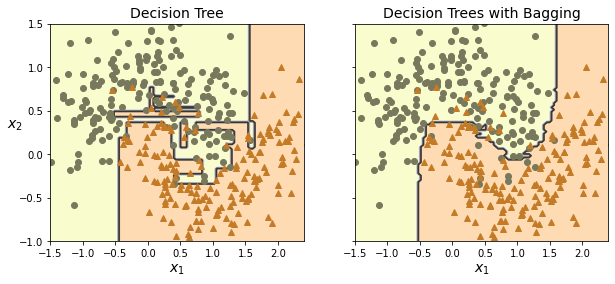

In [9]:
import numpy as np 
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)


def plot_decision_boundary(clf, X, y, alpha=1.0):
    axes=[-1.5, 2.4, -1, 1.5]
    x1, x2 = np.meshgrid(np.linspace(axes[0], axes[1], 100),
                         np.linspace(axes[2], axes[3], 100))
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    
    plt.contourf(x1, x2, y_pred, alpha=0.3 * alpha, cmap='Wistia')
    plt.contour(x1, x2, y_pred, cmap="Greys", alpha=0.8 * alpha)
    colors = ["#78785c", "#c47b27"]
    markers = ("o", "^")
    for idx in (0, 1):
        plt.plot(X[:, 0][y == idx], X[:, 1][y == idx],
                 color=colors[idx], marker=markers[idx], linestyle="none")
    plt.axis(axes)
    plt.xlabel(r"$x_1$")
    plt.ylabel(r"$x_2$", rotation=0)

tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X_train, y_train)
plt.title("Decision Tree")
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X_train, y_train)
plt.title("Decision Trees with Bagging")
plt.ylabel("")
plt.show()

Decision boundary 
- compare decision boundary of a single decision treee with the bagging ensemble of 500 tree on the moons dataset 
- the ensemble prediction will likely generalize much better than the single decision tree predictions 
- the ensemble has comparable bias but a smaller varianve (it makes roughly the same number of error on the training set but the decision boundary is less irregular)

- bagging introduce a bit more diversity in the subset that each predictor is trained on, so bagging end up with a slighly higher bias than pasting 
- but the extra diversity also means that the predictors end up being less correlated, so the ensemble variance is reduced 
- overall bagging often result in better models which explain why its generaly prefered 
- ut if we have sparse time and cpu power we can use cross validation to evaluate both bagging and pastting and select the one that work best 

### Out-of-Bag Evaluation

- with bagging some training instance may be sampled several times fir any given predictor, while other may be not be samples at all 
- by default a bgging classifier sample m training instance with replacement (bootstrap=true), where m is the size of the training set 
- whit this process it can be shown mathematically that only about 63% of the training instance are sampled on average for each predictor
- tha remaining 37% of the training instance that are not sample are called out of bag (oob) instance 
- note that they are not the same 37% for all predictors


- a bagging ensemble can be evaluated using oob instance without the need for a separate validation set 
- if there are enaugh estomators, then each instance in the training set will likelu be an obb instance of several estimators so these estimators can be used to make a fair ensemble prediction for that instance 
- once we have a prediction for each instanve we can compute the ensemble prediction accuracy or any other metric 
- in scikit lean we can set oob_score_True when creating a bagging classifier to request an automatic oob evaluation after training 

In [10]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500, oob_score=True, n_jobs=-1, random_state=42)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.896

- according to this oob evaluation this bagging classifier is likely to achive about 89.6% accuracy on the test set 

In [11]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.92

- we get 92% accuracy on the test set 
- the obb evalution was a bit too pesismistic just over 2% too low

decision function for each training
- the obb decision function for each training instance is also availeble throught the oob_decision_function_ attribute 
- since the base estimator has a predict_proba() method the decision function return the class probabilities for each training instance 

In [12]:
bag_clf.oob_decision_function_[:3]

array([[0.32352941, 0.67647059],
       [0.3375    , 0.6625    ],
       [1.        , 0.        ]])

### Random Pacthes and Random Subspaces

- bagging classifier class support sampong the feature as well 
- sampling is controled by two hyperparameter: max_features and bootrstp_features
- they work the same way as max_samples and bootstrap but for feature sampling instead of instance sampling
- thus each predictor will be trained on a random subset of the input features 

note:
- selain bootstrap dapat disampling pada "row" 
- sampling juga dapat dilakukan pada feature atau kolon jika terdapat bnayk kolom 

Random patches method
- this technique is particulary usefull when are dealing with hig dimensional input (such as images), as it can considerable speed up training 
- "sampling both training instance and features" is called the random patches methods 


Random subspace method
- "keeping all training instance" (by setting bootstrap=false adna max_sample=1) "but sampling feature"(by setting bootstrap_features to true and or max feature to a values smaler than 1.0)
- is called the random subspace method

### Random Forests

- random forest is an ensemble of decision tree generaly rained via the bagging methd (or sometime pasting), 
- typically max_samples set to the size of the training set 
- instead of building a bagging classifier and passing it a decsion tree classifier we can use the random forest classifier class 
- which is more convenient and optimized for decision trees

- the folowing cose train a random forest classifier with 500 tree
- max 16 leaf ndoes 
- using all available cpu

In [13]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1, random_state=42)
rnd_clf.fit(X_train, y_train)
y_pred_rf = rnd_clf.predict(X_test)

- with a few exception a random forest classifier has all the hyperparameter of a decision tree classifier plus all the hyperparameter of a bagging classifier to control the ensemble it self 

- the following baggingclassifier is equivalent to the previous randomforestclassifier

In [15]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(max_features="sqrt", max_leaf_nodes=16),
                            n_estimators=500, n_jobs=-1, random_state=42)

### Extra Trees

- when we are growing a tree in a random forest at each node only a random subset of the features is considered for splitting 
- it is possible to make tree even more random by also using random treshold for each feature rather than seraching for the best possible tresholds (like regular decision tree)
- for this simple set splitter='random' when creating decision tree classifier 

Extremly randomized trees
- a forest of such extremly random tree is called an extremly randomized trees ensemble
- this trade more bias for a lower variance 
- it also make extra tree classifier much faster to train than regular random forest because finding the best possible treshold for each feature at every node is one of the most time consuming task of growing a tree

In sicikit learn 
- ExtraTreeClassifier class api identical to random forest classifier class excep bootstarp default to false 

### Feature Importance 

- another quality of random forest is that they make it easy to measure the relative importance of each feature
- scikit learn measure a feature importance by looking at how much the tree nodes that use that features reduce impurity in average across all trees in the forest 
- more precisely it is a weighted average whre each node weight is equal to the number of training samples that are associated woth it 
- scikit learn compute the score automaticaly for each feature after training then scale the result so that the sum of all features is equal to 1
- we can acces using feature_importances_ variable

In [16]:
from sklearn.datasets import load_iris
iris = load_iris(as_frame=True)
rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42)
rnd_clf.fit(iris.data, iris.target)

for score, name in zip(rnd_clf.feature_importances_, iris.data.columns):
    print(round(score, 2), name)

0.11 sepal length (cm)
0.02 sepal width (cm)
0.44 petal length (cm)
0.42 petal width (cm)


- similarly if we train a random forest classifier on the mnist dataset and plot each pixel importance we get the image represented
- random forest are very handy to get a quick understanding of what feature actually mater, in particulr if we need to perform feature selection

### Boosting

Boosting 
- orginaly called hypothesis boosting refers to any ensemble method that can combine several weak learners into a stong learner 
- the general idea of most boosting method is to trai predictor sequentially each trying to correct its predecessor 
- there are many boosting metjod availabele but by far most popular are adaboost and gradient boosting


## AdaBoost

- one way for a new predictor o correct its predecessor is to pay a bit more attantion to the training instance that the predecessor underfit
- this resukt in new predictor focusing more an more on the hard case 
- this is the technique used by adaboost

example
- when training an adaboost classifier
- the algorithm first train a base classifier such as decision tree and uses it to make predictorn on the training set 
- the algorithm then increase the relative weight of misclasisified training instance 
- then it train a second classifier using update weight and again make prediction on the training set update the instance weight asn so on 

- we can see this sequential learning technique has some similarities with gradient descent except that instead of tweaking a single predictor parameter to minimize a cost function 
- adaboost adds predictor to the ensemble gradually making it better

- once all predictor are trained, the ensemble make prediction very much like bagging or pasting
- except the predictor have different weight depending on the overrall accuracy on the weighted training set 

warning 
- there is one important drawback to this sequential learning technique 
- training canot be parallelized since each predictor can only be trained aftre the previous predictor has been trained and evaluates 
- as a result it does not scale as well as bagging or pasting


in scikit learn 
- the folowing code train an adaboost classifir based on 30 deicison stup using scikit leas adaboostclassifier class 
- a decide stump is decision tree with max depth -1 in other word a tree composed of a single decision node plus 2 leaf nodes 
- this is the default base estimator for the adaboostclassifier class

In [17]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=30, learning_rate=0.5, random_state=42
)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=30, random_state=42)

Tip 
- if adaboost ensemble is overfitting the traing set
- we can try reducing the number of estimator or more strongly reqularozes the base estimator

### Gardient Boosting

- gradient boosting works by sequeantially adding predictor to an ensemble each one correcting its predecessor 
- instead of tweaking the instance weight at every iteration like adaboost does this method tries to fit new predictor to the residual error made by the previous predictor 

- simple regression example 
- using decision tree as the base predictors this calles graident tree boosting or gradient boosted regression tree (gbrt)

In [18]:
import numpy as np 
from sklearn.tree import DecisionTreeRegressor

np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3 * X[:, 0] ** 2 + 0.05 * np.random.randn(100)

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

- next we'll train a second decision tree regresor on the residual error made by the first predictor

In [19]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=43)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2, random_state=43)

- and then we'll train a third regressor on the residual erroe made by he second predictor

In [20]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=44)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2, random_state=44)

- now we have an ensemble containing three trees 
- it can make prediction oan new instance simple by adding up the prediction of all the trees

In [21]:
X_new = np.array([[-0.4], [0.], [0.5]])
sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

array([0.49484029, 0.04021166, 0.75026781])

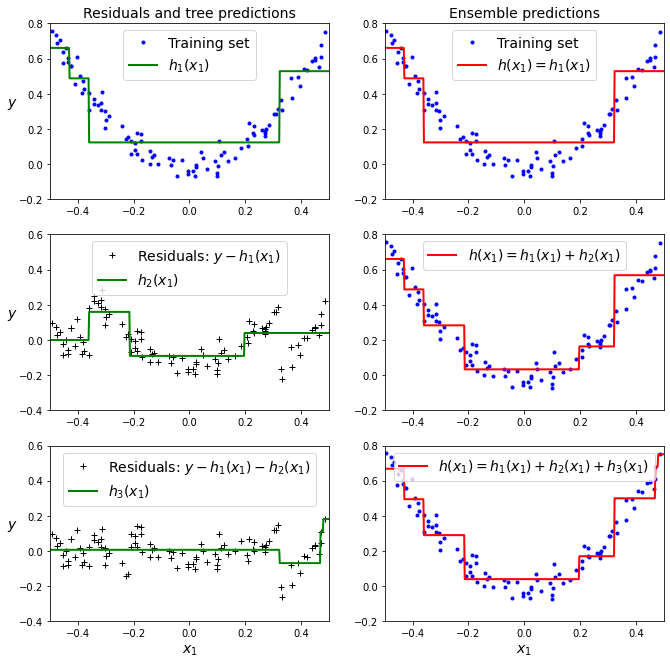

In [22]:
def plot_predictions(regressors, X, y, axes, style,
                     label=None, data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1))
                 for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center")
    plt.axis(axes)

plt.figure(figsize=(11, 11))

plt.subplot(3, 2, 1)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.2, 0.8], style="g-",
                 label="$h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$  ", rotation=0)
plt.title("Residuals and tree predictions")

plt.subplot(3, 2, 2)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.2, 0.8], style="r-",
                 label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.title("Ensemble predictions")

plt.subplot(3, 2, 3)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.4, 0.6], style="g-",
                 label="$h_2(x_1)$", data_style="k+",
                 data_label="Residuals: $y - h_1(x_1)$")
plt.ylabel("$y$  ", rotation=0)

plt.subplot(3, 2, 4)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.2, 0.8],
                  style="r-", label="$h(x_1) = h_1(x_1) + h_2(x_1)$")

plt.subplot(3, 2, 5)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.4, 0.6], style="g-",
                 label="$h_3(x_1)$", data_style="k+",
                 data_label="Residuals: $y - h_1(x_1) - h_2(x_1)$")
plt.xlabel("$x_1$")
plt.ylabel("$y$  ", rotation=0)

plt.subplot(3, 2, 6)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y,
                 axes=[-0.5, 0.5, -0.2, 0.8], style="r-",
                 label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$")

plt.show()

- represnt the prediction of these three trees in the left column 
- and the ensemble prediction in right colmn 
- in the first row the ensemble has just one tree so its prediction are exactly the same as the fisrt tree predictions 
- in the secodn row  a new tree is trained on the residual error of the first tree, on the right we can see that the ensemble prediction are equal to the sum of the prediction of the forst two trees
- similarly in the third row another tree is trained on the residual error od the secodn tree 
- we can see that the ensemble prediction gradualy get better as tree are added to the ensemble